## Visual Geometry Group Models (VGG16 & VGG19)
Documentation to be filled up later BLABLABLA

### Installation and Import Checks

In [1]:
%pip install tensorflow==2.10
%pip install scikit-learn
%pip install matplotlib
%matplotlib inline
%pip install keras_tuner
%pip install seaborn
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
# Machine Learning
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import keras_tuner as kt
import seaborn as sns
from tabulate import tabulate
# Plotting
import matplotlib.pyplot as plt
import pandas as pd
import os

### Optional: GPU Acceleration Check
Checks Tensorflow Version and GPU detection. 
If GPU detected, output should be something like "Num GPUs Available:  1"

In [3]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices()
print("Physical Devices:", physical_devices)

TensorFlow version: 2.10.0
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load and Split Prepared Data
Loads in preprocessed data from the ./prepared_data directory for x and y features. 

In [4]:
# Load the data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

# Set seed for reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
# 3. Set the NumPy random seed
np.random.seed(seed_value)
# 4. Set the TensorFlow random seed
tf.random.set_seed(seed_value)

# Ensure y is output hot coded
y_output = to_categorical(y_output, num_classes=4)
# Resizes images to 224 x 224 for optimal size for VGG models
x_input_resized = np.array([tf.image.resize(image, (224, 224)).numpy() for image in x_input])

Splits for training and testing 80/20 ratio

In [5]:
# Split the data into training and testing sets
x_input_train, x_input_test, y_output_train, y_output_test = train_test_split(x_input_resized, y_output, test_size=0.2, random_state=seed_value)

# Printing Dimensions of data
print(f'X Training Data\nNumber of Rows: {x_input_train.shape[0]}\nPixel Dimensions: {x_input_train.shape[1]}x{x_input_train.shape[2]}x{x_input_train.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_train.shape[0]}\nNumber of Classes: {y_output_train.shape[1]}\n')
print(f'X Testing Data\nNumber of Rows: {x_input_test.shape[0]}\nPixel Dimensions: {x_input_test.shape[1]}x{x_input_test.shape[2]}x{x_input_test.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_test.shape[0]}\nNumber of Classes: {y_output_test.shape[1]}')

X Training Data
Number of Rows: 1536
Pixel Dimensions: 224x224x3

Y Training Data
Number of Rows: 1536
Number of Classes: 4

X Testing Data
Number of Rows: 384
Pixel Dimensions: 224x224x3

Y Training Data
Number of Rows: 384
Number of Classes: 4


### Optional: Hyperparameter Optimisation
For the most optimal parameters (neurons, dropouts, learning rates), the Keras Tuner was used on the VGG16 model which was less computationally expensive than its VGG19 counterpart. One function was used to create the model, the other to define how the tuning was done. 

The output of the Hyperparameter Optimisation were as follows
* 640 neurons for first dense layer
* 0.2 dropout rate for first dropout layer
* 512 neurons for second dense layer
* 0.4 dropout rate for both second dropout layer
* 0.0005 learning rate

These hyperparameters were used for both the VGG16 & VGG19 models

In [6]:
# # Function to build the model
# def build_model(hp):
#     base_vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
#     for layer in base_vgg16_model.layers:
#         layer.trainable = False

#     x = base_vgg16_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = BatchNormalization()(x)
    
#     # Tune the number of units in the first dense layer
#     units_1 = hp.Int('units_1', min_value=512, max_value=1024, step=128)
#     x = Dense(units_1, activation='relu', kernel_constraint=max_norm(3))(x)
    
#     # Tune the dropout rate
#     dropout_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
#     x = Dropout(dropout_1)(x)
    
#     # Tune the number of units in the second dense layer
#     units_2 = hp.Int('units_2', min_value=256, max_value=512, step=128)
#     x = Dense(units_2, activation='relu', kernel_constraint=max_norm(3))(x)
    
#     # Tune the dropout rate
#     dropout_2 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
#     x = Dropout(dropout_2)(x)
    
#     new_output_layer_vgg16 = Dense(4, activation='softmax')(x)  # 4 classes: no tumor, glioma, meningioma, pituitary
    
#     model = Model(inputs=base_vgg16_model.input, outputs=new_output_layer_vgg16)
    
#     # Tune the learning rate
#     learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4])
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])
    
#     return model

In [7]:
# # Set up the tuner
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=30,
#     executions_per_trial=1,
#     directory='kt_tuning/kt_tuner_vggtest',
#     project_name='brain_tumor_classification'
# )

# # Define callbacks
# checkpoint = ModelCheckpoint('model_checkpoints/vgg16_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# # Run the hyperparameter search
# tuner.search(x_input_train, y_output_train, epochs=50, validation_data=(x_input_test, y_output_test), callbacks=[checkpoint, early_stopping])

# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The optimal number of units in the first dense layer is {best_hps.get('units_1')}.
# The optimal dropout rate for the first dropout layer is {best_hps.get('dropout_1')}.
# The optimal number of units in the second dense layer is {best_hps.get('units_2')}.
# The optimal dropout rate for the second dropout layer is {best_hps.get('dropout_2')}.
# The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
# """)

### Define VGG Models
In this segment, pretrained VGG models are called from TensorFlow. These models are configured to receive its weightages trained from the ImageNet dataset and to receive a 224x224x3 image input. The top layer is also removed for further improvements. 
* weights='imagenet' > Loads weightages from ImageNet data training
* include_top = False > Exclude top layers of model, to add custom top layers (tuning with our data)
* input_shape > Specify the dimensions of our input data, which is given as 224 x 224 pixels and 3 representing color channels in each image (RGB)



#### Defining Model VGG16

In [8]:
# Load the VGG16 model pre-trained on ImageNet
base_vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In place of the last layer that was dropped, new layers are defined to fine tune the base model to our use case. These layers will have their weights altered based on the data we train it on. For other model layers, they are frozen to prevent any amendments to weightage. 

Resources for Layering Operations:
* How Global Average Pooling works: https://saturncloud.io/blog/understanding-the-difference-between-flatten-and-globalaveragepooling2d-in-keras/#:~:text=with%20nine%20elements.-,What%20is%20GlobalAveragePooling2D()%20in%20Keras%3F,an%20operation%20on%20the%20data.
* How Batch Normalisation works: https://arxiv.org/abs/1502.03167
* How kernal constraints works: https://keras.io/api/layers/constraints/#:~:text=MaxNorm%20class&text=Constrains%20the%20weights%20incident%20to,max_norm%20.
* How dropout layers works: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout#:~:text=The%20Dropout%20layer%20randomly%20sets,over%20all%20inputs%20is%20unchanged.


In [9]:
# Adds average pool layer to reduce dimensionality of feature maps
new_layers_vgg16 = GlobalAveragePooling2D()(base_vgg16_model.output)
# Adds a normalisation layer to enhance performance with bigger batch sizes (32)
new_layers_vgg16 = BatchNormalization()(new_layers_vgg16)
# Add first dense layer of 1024 neurons with RELU, adds weight constraints, regularising weights directly
new_layers_vgg16 = Dense(640, activation='relu', kernel_constraint=max_norm(3))(new_layers_vgg16)
# Add first dropout layer with 20% dropout rate to avoid overfitting   
new_layers_vgg16 = Dropout(0.2)(new_layers_vgg16)
# Add second dense layer of 384 neurons with RELU, adds weight constraints, regularising weights directly
new_layers_vgg16 = Dense(512, activation='relu', kernel_constraint=max_norm(3))(new_layers_vgg16)
# Add second dropout layer with 20% dropout rate to avoid overfitting  
new_layers_vgg16 = Dropout(0.4)(new_layers_vgg16)
# Add final output layer with four neurons corresponding to four classes with activation as softmax to predict probability of each class
output_layer_vgg16 = Dense(4, activation='softmax')(new_layers_vgg16)

# Define the model
vgg16_model = Model(inputs=base_vgg16_model.input, outputs=output_layer_vgg16)

# Freeze the layers of the base model
for layer in base_vgg16_model.layers:
    layer.trainable = False

#### Defining Model VGG19

In [10]:
# Load the VGG19 model pre-trained on ImageNet 
base_vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [11]:
# Adds average pool layer to reduce dimensionality of feature maps
new_layers_vgg19 = GlobalAveragePooling2D()(base_vgg19_model.output)
# Adds a normalisation layer to enhance performance with bigger batch sizes (32)
new_layers_vgg19 = BatchNormalization()(new_layers_vgg19)
# Add first dense layer of 1024 neurons with RELU, adds weight constraints, regularising weights directly
new_layers_vgg19 = Dense(640, activation='relu', kernel_constraint=max_norm(3))(new_layers_vgg19)
# Add first dropout layer with 20% dropout rate to avoid overfitting   
new_layers_vgg19 = Dropout(0.2)(new_layers_vgg19)
# Add second dense layer of 384 neurons with RELU, adds weight constraints, regularising weights directly
new_layers_vgg19 = Dense(512, activation='relu', kernel_constraint=max_norm(3))(new_layers_vgg19)
# Add second dropout layer with 20% dropout rate to avoid overfitting  
new_layers_vgg19 = Dropout(0.4)(new_layers_vgg19)
# Add final output layer with four neurons corresponding to four classes with activation as softmax to predict probability of each class
output_layer_vgg19 = Dense(4, activation='softmax')(new_layers_vgg19)

# Define the model
vgg19_model = Model(inputs=base_vgg19_model.input, outputs=output_layer_vgg19)

# Freeze the layers of the base model
for layer in base_vgg19_model.layers:
    layer.trainable = False

### Training the VGG Models
In this segment, the models were configured to be compiled using the
* Adam's Optimizer
* Categorical Cross Entropy for Multi-Class Classification
* Accuracy

Checkpoints were defined to save best models based on validation loss. 

#### Training Model VGG16

In [12]:
# Compile the model
vgg16_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Define callbacks
checkpoint_vgg16 = ModelCheckpoint('model_checkpoints/vgg16_brain_tumor.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_vgg16 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
vgg16_history = vgg16_model.fit(x_input_train, y_output_train, epochs=50, validation_data=(x_input_test, y_output_test), 
                    callbacks=[checkpoint_vgg16, early_stopping_vgg16])

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.7841 - accuracy: 0.6803 - precision: 0.7757 - recall: 0.5807
Epoch 1: val_loss improved from inf to 1.18609, saving model to model_checkpoints\vgg16_brain_tumor.keras
48/48 [==============================] - 5s 79ms/step - loss: 0.7841 - accuracy: 0.6803 - precision: 0.7757 - recall: 0.5807 - val_loss: 1.1861 - val_accuracy: 0.4896 - val_precision: 1.0000 - val_recall: 0.0339
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8652 - precision: 0.8923 - recall: 0.8249
Epoch 2: val_loss improved from 1.18609 to 1.04594, saving model to model_checkpoints\vgg16_brain_tumor.keras
48/48 [==============================] - 4s 74ms/step - loss: 0.3918 - accuracy: 0.8652 - precision: 0.8923 - recall: 0.8249 - val_loss: 1.0459 - val_accuracy: 0.4870 - val_precision: 0.7850 - val_recall: 0.2188
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9245 - pr

#### Training Model VGG19

In [13]:
# Compile the model
vgg19_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

# Define callbacks
checkpoint_vgg19 = ModelCheckpoint('/model_checkpoints/vgg19_brain_tumor.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_vgg19 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
vgg19_history = vgg19_model.fit(x_input_train, y_output_train, epochs=50, validation_data=(x_input_test, y_output_test), 
                    callbacks=[checkpoint_vgg19, early_stopping_vgg19])

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.8354 - accuracy: 0.6647 - precision: 0.7654 - recall: 0.5566
Epoch 1: val_loss improved from inf to 1.16278, saving model to /model_checkpoints\vgg19_brain_tumor.keras
48/48 [==============================] - 5s 89ms/step - loss: 0.8354 - accuracy: 0.6647 - precision: 0.7654 - recall: 0.5566 - val_loss: 1.1628 - val_accuracy: 0.6406 - val_precision: 1.0000 - val_recall: 0.0234
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.8301 - precision: 0.8659 - recall: 0.7988
Epoch 2: val_loss improved from 1.16278 to 1.07223, saving model to /model_checkpoints\vgg19_brain_tumor.keras
48/48 [==============================] - 4s 85ms/step - loss: 0.4688 - accuracy: 0.8301 - precision: 0.8659 - recall: 0.7988 - val_loss: 1.0722 - val_accuracy: 0.7083 - val_precision: 1.0000 - val_recall: 0.0312
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.8730 - 

### Evaluation using Model Performance & Classification Metrics
Overall model Performance to be Plotted using Training/Validation over Epoches
* Loss 
* Accuracy
* Precision
* Recall

These model performance will be further drilled down in the confusion matrix and the classification report, where we will observe numbers for
* True Positive
* True Negatives
* False Positives
* False Negatives

In [14]:
def plot_model_performance(history, title):
    """Plot training and validation loss, accuracy, precision, and recall, and print metrics in a table format."""
    epochs = range(1, len(history.history['loss']) + 1)
    data = {
        'Epoch': epochs,
        'Training Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss'],
        'Training Accuracy': history.history['accuracy'],
        'Validation Accuracy': history.history['val_accuracy'],
        'Training Precision': history.history['precision'],
        'Validation Precision': history.history['val_precision'],
        'Training Recall': history.history['recall'],
        'Validation Recall': history.history['val_recall']
    }
    df = pd.DataFrame(data)
    
    # Print the metrics in a table format using tabulate
    print(tabulate(df, headers='keys', tablefmt='pretty'))
    
    plt.figure(figsize=(10, 20))  # Adjust the figure size for better visibility

    # Plot loss
    plt.subplot(4, 1, 1)  # 4 rows, 1 column, first subplot
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(4, 1, 2)  # 4 rows, 1 column, second subplot
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Fix the accuracy scale from 0 to 1
    plt.yticks([i / 10.0 for i in range(11)])  # Set y-ticks to show labels at intervals of 0.1
    plt.legend()
    plt.grid(True)

    # Plot precision
    plt.subplot(4, 1, 3)  # 4 rows, 1 column, third subplot
    plt.plot(epochs, history.history['precision'], label='Training Precision')
    plt.plot(epochs, history.history['val_precision'], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.ylim(0, 1)  # Fix the precision scale from 0 to 1
    plt.yticks([i / 10.0 for i in range(11)])  # Set y-ticks to show labels at intervals of 0.1
    plt.legend()
    plt.grid(True)

    # Plot recall
    plt.subplot(4, 1, 4)  # 4 rows, 1 column, fourth subplot
    plt.plot(epochs, history.history['recall'], label='Training Recall')
    plt.plot(epochs, history.history['val_recall'], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.ylim(0, 1)  # Fix the recall scale from 0 to 1
    plt.yticks([i / 10.0 for i in range(11)])  # Set y-ticks to show labels at intervals of 0.1
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
    plt.show()

def plot_confusion_matrix(model):
    """Evaluate a trained model on test data and display the confusion matrix and classification report."""
    # Class labels
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    # Predict the labels for the test data
    predictions = model.predict(x_input_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_output_test, axis=1)
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Print the classification report using tabulate
    report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    print("Classification Report:")
    print(tabulate(report_df, headers='keys', tablefmt='pretty'))

#### Simple & Classification Metrics for Model VGG16

+----+-------+----------------------+---------------------+--------------------+---------------------+--------------------+----------------------+--------------------+--------------------+
|    | Epoch |    Training Loss     |   Validation Loss   | Training Accuracy  | Validation Accuracy | Training Precision | Validation Precision |  Training Recall   | Validation Recall  |
+----+-------+----------------------+---------------------+--------------------+---------------------+--------------------+----------------------+--------------------+--------------------+
| 0  |  1.0  |  0.784052312374115   |  1.186093807220459  | 0.6803385615348816 | 0.4895833432674408  | 0.7756521701812744 |         1.0          | 0.5807291865348816 | 0.0338541679084301 |
| 1  |  2.0  |  0.3918375074863434  | 1.0459425449371338  |    0.865234375     | 0.4869791567325592  | 0.8922535181045532 |  0.7850467562675476  | 0.8248698115348816 |      0.21875       |
| 2  |  3.0  | 0.22443126142024994  | 0.839647293090820

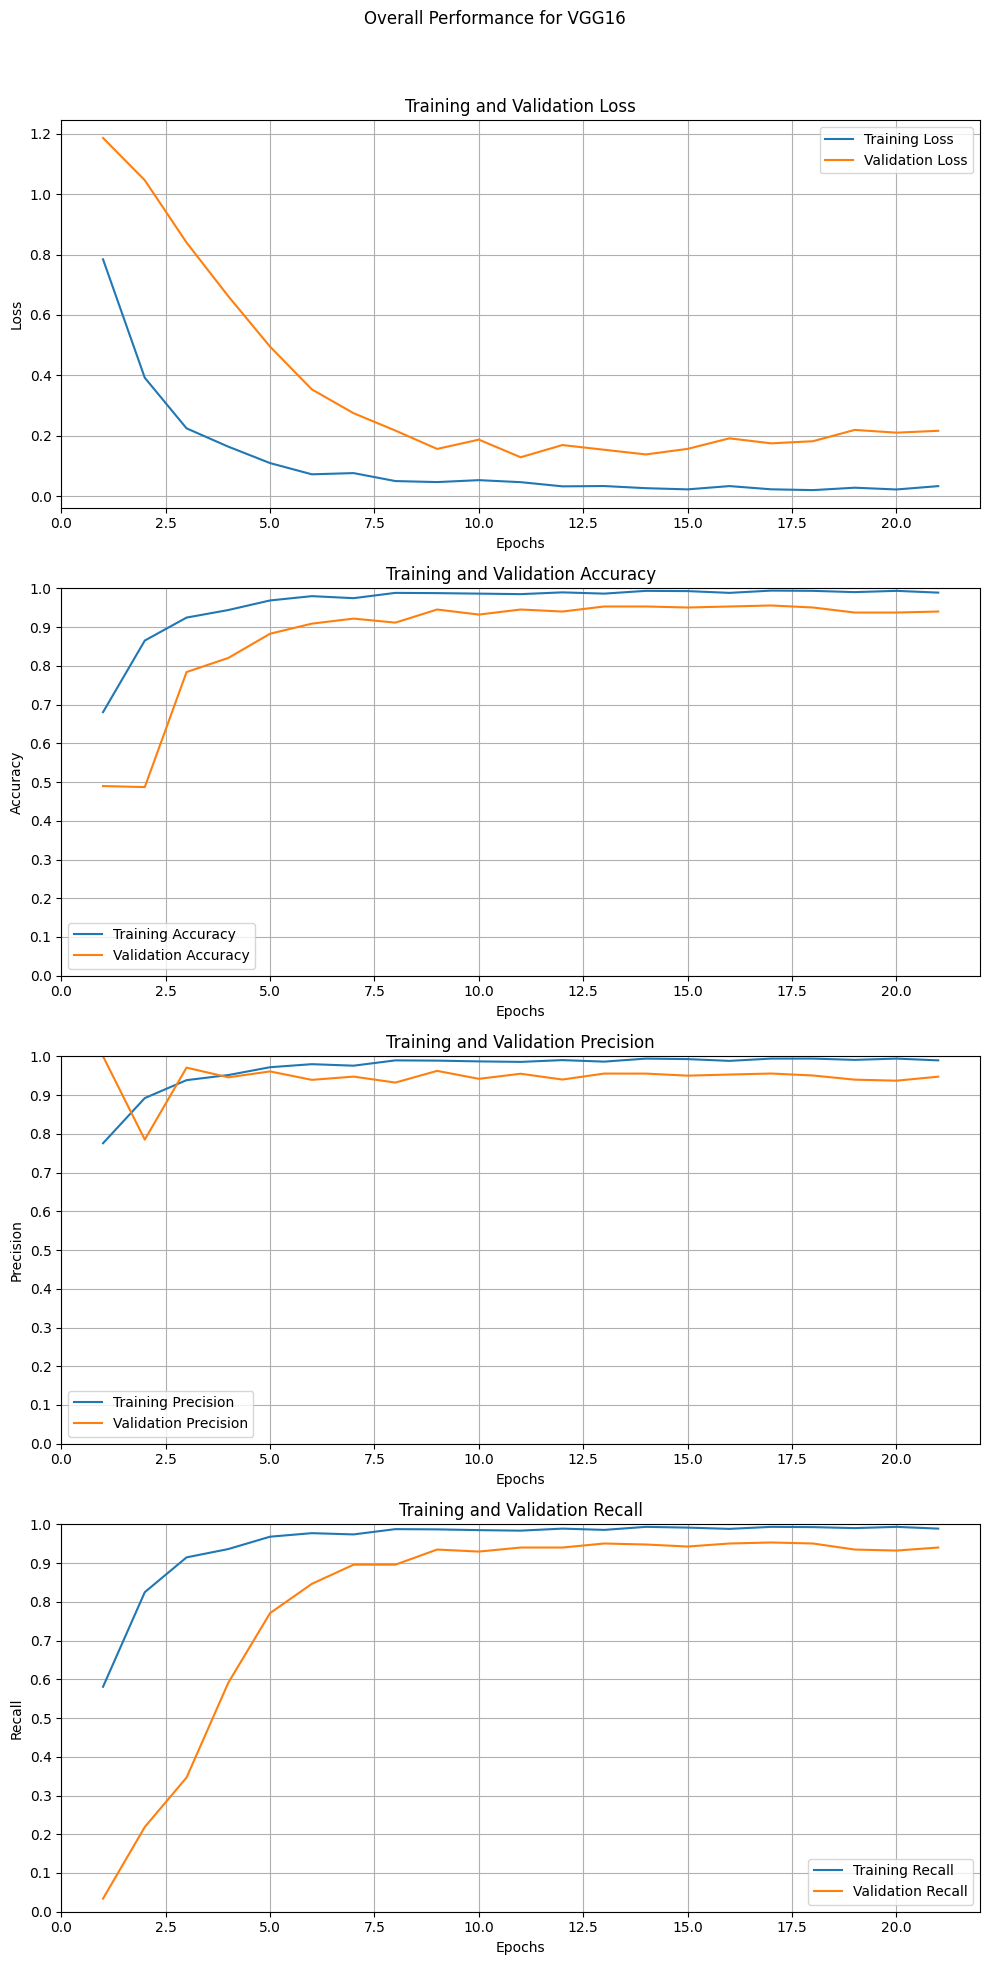

12/12 [==============================] - 1s 65ms/step


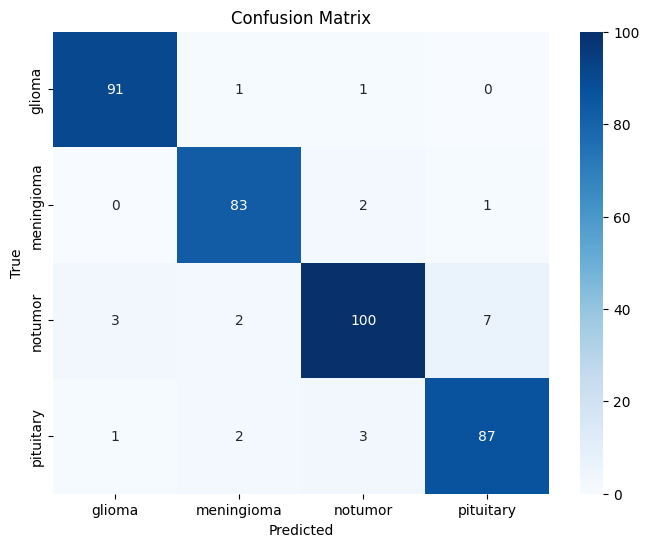

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|    glioma    | 0.9578947368421052 | 0.978494623655914  | 0.9680851063829787 |        93.0        |
|  meningioma  | 0.9431818181818182 | 0.9651162790697675 | 0.9540229885057471 |        86.0        |
|   notumor    | 0.9433962264150944 | 0.8928571428571429 | 0.9174311926605505 |       112.0        |
|  pituitary   | 0.9157894736842105 | 0.9354838709677419 | 0.925531914893617  |        93.0        |
|   accuracy   | 0.9401041666666666 | 0.9401041666666666 | 0.9401041666666666 | 0.9401041666666666 |
|  macro avg   | 0.9400655637808071 | 0.9429879791376415 | 0.9412678006107233 |       384.0        |
| weighted avg | 0.9401735554715477 | 0.9401041666666666 | 0.9398558

In [15]:
plot_model_performance(vgg16_history, "Overall Performance for VGG16")
plot_confusion_matrix(vgg19_model)

#### Simple & Classification Metrics for Model VGG19

+----+-------+----------------------+---------------------+--------------------+---------------------+--------------------+----------------------+--------------------+--------------------+
|    | Epoch |    Training Loss     |   Validation Loss   | Training Accuracy  | Validation Accuracy | Training Precision | Validation Precision |  Training Recall   | Validation Recall  |
+----+-------+----------------------+---------------------+--------------------+---------------------+--------------------+----------------------+--------------------+--------------------+
| 0  |  1.0  |  0.8353657722473145  | 1.1627767086029053  | 0.6647135615348816 |      0.640625       | 0.7654431462287903 |         1.0          |    0.556640625     |     0.0234375      |
| 1  |  2.0  |  0.4687710702419281  | 1.0722332000732422  |    0.830078125     | 0.7083333134651184  | 0.8659139275550842 |         1.0          |    0.798828125     |      0.03125       |
| 2  |  3.0  | 0.34236177802085876  | 0.962135970592498

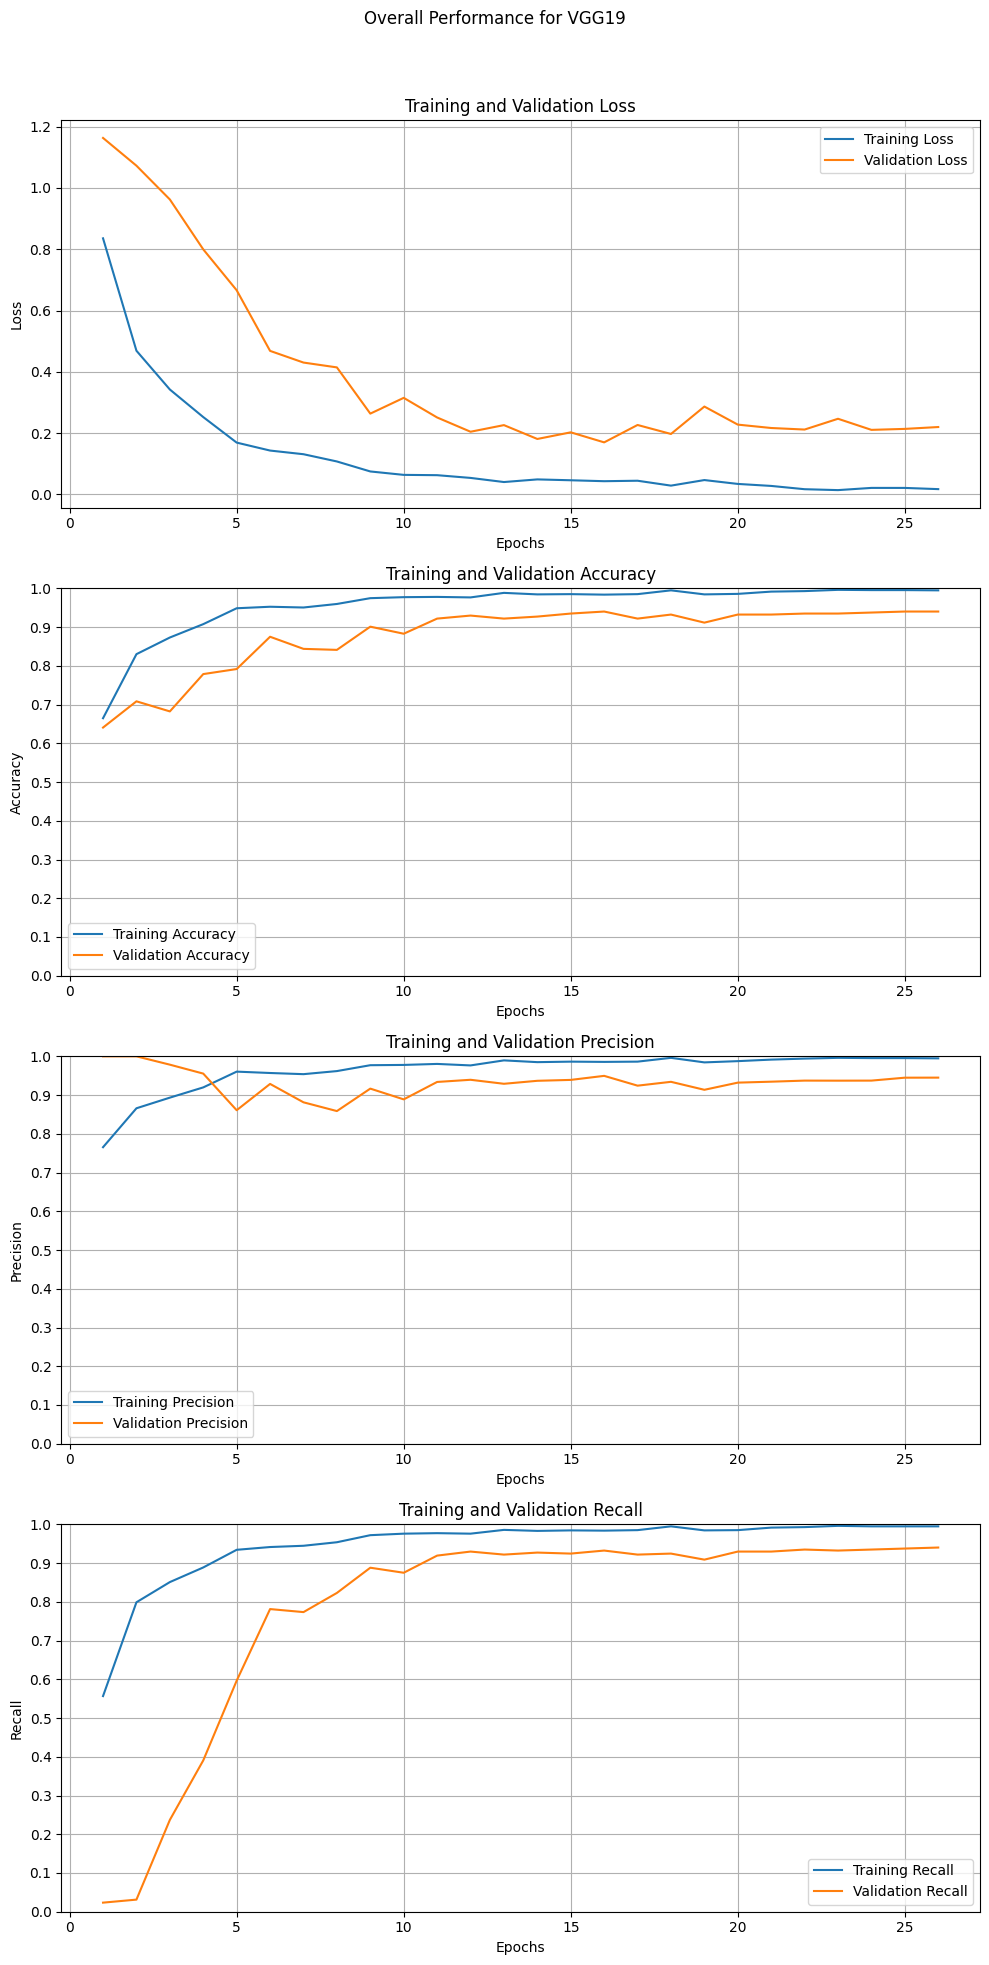

12/12 [==============================] - 1s 64ms/step


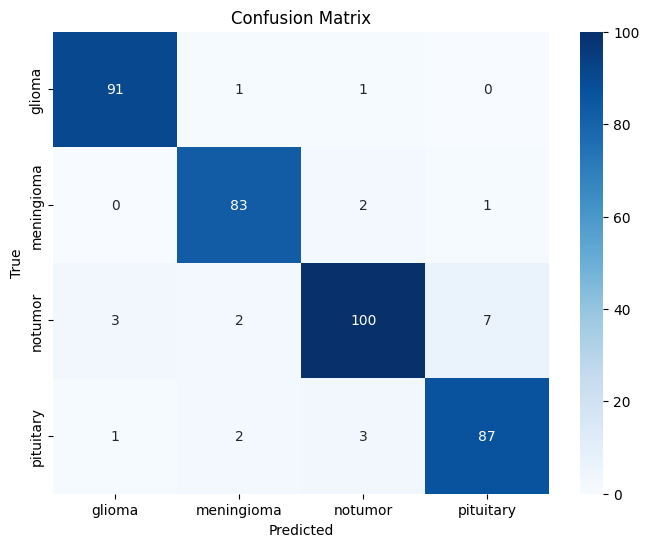

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|    glioma    | 0.9578947368421052 | 0.978494623655914  | 0.9680851063829787 |        93.0        |
|  meningioma  | 0.9431818181818182 | 0.9651162790697675 | 0.9540229885057471 |        86.0        |
|   notumor    | 0.9433962264150944 | 0.8928571428571429 | 0.9174311926605505 |       112.0        |
|  pituitary   | 0.9157894736842105 | 0.9354838709677419 | 0.925531914893617  |        93.0        |
|   accuracy   | 0.9401041666666666 | 0.9401041666666666 | 0.9401041666666666 | 0.9401041666666666 |
|  macro avg   | 0.9400655637808071 | 0.9429879791376415 | 0.9412678006107233 |       384.0        |
| weighted avg | 0.9401735554715477 | 0.9401041666666666 | 0.9398558

In [16]:
plot_model_performance(vgg19_history, "Overall Performance for VGG19")
plot_confusion_matrix(vgg19_model)